In [1]:
print("Global2 kernel and ipykernel 6.30.1 working fine")

Global2 kernel and ipykernel 6.30.1 working fine


In [2]:
import langchain
print("Langchain version:", langchain.__version__)

Langchain version: 0.3.27


In [4]:
from langgraph.graph import StateGraph, END
from pydantic import BaseModel
from typing import List
from langchain_core.messages import AnyMessage

# ---- Dummy State Model ----
class RAGState(BaseModel):
    messages: List[AnyMessage] = []
    youtube_link: str = ""
    transcription: str = ""
    summarized_context: str = ""
    final_answer: str = ""

# ---- Dummy Nodes ----
def check_url_node(state: RAGState) -> str:
    return "transcribe"  # or "not_transcribe"

def transcribe_node(state: RAGState) -> RAGState:
    return state

def retrieval_node(state: RAGState) -> RAGState:
    return state

def chat_node(state: RAGState) -> RAGState:
    return state

# ---- Build Graph ----
graph_builder = StateGraph(RAGState)

graph_builder.add_node("Check_URL_Node", check_url_node)
graph_builder.add_node("Transcribe_Node", transcribe_node)
graph_builder.add_node("Retrieval_Node", retrieval_node)
graph_builder.add_node("Chat_Node", chat_node)

graph_builder.set_entry_point("Check_URL_Node")

graph_builder.add_conditional_edges(
    source="Check_URL_Node",
    path=check_url_node,
    path_map={
        "transcribe": "Transcribe_Node",
        "not_transcribe": "Retrieval_Node"
    }
)

graph_builder.add_edge("Transcribe_Node", "Retrieval_Node")
graph_builder.add_edge("Retrieval_Node", "Chat_Node")

graph_builder.set_finish_point("Chat_Node")

# ---- Compile without checkpoint/store ----
graph = graph_builder.compile()


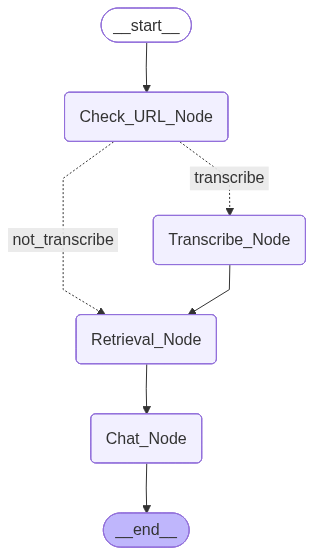

In [5]:
graph

In [ ]:
💯 Excellent question — and **you’re absolutely right** to ask this, because how you handle the **`thread_id`** determines how your **checkpointer (memory)** behaves across multiple YouTube videos per user.

Let’s break it down very simply 👇

---

## 🧠 What is `thread_id` in LangGraph?

The `thread_id` acts like a **conversation or session ID**.
LangGraph uses it to know *“which conversation / flow / memory checkpoint belongs to what.”*

---

## 🧩 In your case: user + multiple YouTube URLs

You have this logic:

```python
namespace = (user_email, youtube_url)
```

That ensures each user–video pair is **unique in the vector store** (for retrieval).
Now, the **thread_id** should match that same pattern — otherwise, checkpoints (state memory) might mix between different videos.

---

## ✅ Best Practice

Use **1 thread per video per user**, e.g.:

```python
thread_id = f"{user_email}_{hash(youtube_url)}"
```

or if you want it shorter:

```python
import hashlib

thread_id = hashlib.md5(f"{user_email}_{youtube_url}".encode()).hexdigest()
```

This ensures:

* ✅ Each user’s YouTube video transcription has its **own LangGraph state**
* ✅ When they transcribe another video, it creates a **new independent session**
* ✅ Checkpoints are not mixed between different videos

---

## 🔧 Example in context

Here’s how you’d use it inside your code when running the graph:

```python
from utils.db import store, checkpointer

user_email = "user@example.com"
youtube_url = "https://youtube.com/watch?v=abc123"

namespace = (user_email, youtube_url)
thread_id = f"{user_email}_{hash(youtube_url)}"

app = graph.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "user_id": user_email,
        "thread_id": thread_id,  # ✅ important
    }
}

app.invoke({"youtube_link": youtube_url}, config=config)
```

---

## 🧩 Visual summary

| Concept     | Used For                       | Example                       | Effect                             |
| ----------- | ------------------------------ | ----------------------------- | ---------------------------------- |
| `namespace` | Vector store grouping          | (`user_email`, `youtube_url`) | Avoids mixing embeddings           |
| `thread_id` | Checkpointer memory separation | `"user@example.com_abc123"`   | Keeps RAG state isolated per video |
| `user_id`   | Identifying the owner          | `"user@example.com"`          | Shared across their content        |

---

So yes — ✅ **each YouTube URL should have its own `thread_id`** for that user.
That’s the cleanest and safest setup for multi-video transcription without duplication or confusion.

---

Would you like me to show you how to modify your **main `RAG-Bot.py`** to automatically generate and pass this `thread_id` per video?


In [5]:
import sys
import os
__file__ = r"d:\Programming\Python in Sublime\LLM Works\LangGraph Basic\Graphs\Youtube Rag Chatbot\TTS.ipynb"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from utils.db import store

from dotenv import load_dotenv
load_dotenv()


True

In [8]:
# Store some documents
store.put(("user_123", "conversations"), key="msg1", value={"text": "How are you?"},index=['text'])
store.put(("user_123", "conversations"), key="msg2", value={"text": "What's the weather like?"},index=['text'])


In [25]:

# Perform a semantic search
results = store.search(
    ("user_123", "conversations"),
    filter={"text": "How are you?"},
    limit=2
)
for result in results:
    print(f"Text: {result.value['text']}")

Text: How are you?
